In [1]:
import pandas as pd
import re
import textCleaning as tc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("data/tiktok_comments_with_sentiment.csv")
df

,text,createTime,sentiment_score,sentiment_label
0,gibran:,1764933105,-0.014373,neutral
1,ini emg harusnya ganti rakyat sih. bgnian emg ...,1764928295,0.994941,positive
2,wapres aja gak pakek rompi anti peluru,1764922201,0.035081,neutral
3,di indo doang presiden n wapres di hujat wkwk,1764925978,-0.009545,neutral
4,"di X parah bett anjir komenannya, merinding la...",1764922173,0.911693,positive
...,...,...,...,...
4140,dy emg bnr2 idola emak2 indonesia (bahagia)\r\...,1764986048,0.990931,positive
4141,sip saya catat,1764985783,0.964800,positive
4142,"serba salah banget, keliatan dikata pencitraan...",1764985734,0.978314,positive
4143,"mas wapres panen pahala dari para hatter,\r\ns...",1764985669,0.994848,positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             4145 non-null   object 
 1   createTime       4145 non-null   int64  
 2   sentiment_score  4145 non-null   float64
 3   sentiment_label  4145 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 129.7+ KB


In [4]:
df.dropna(inplace=True, subset=['text', 'createTime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145 entries, 0 to 4144
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             4145 non-null   object 
 1   createTime       4145 non-null   int64  
 2   sentiment_score  4145 non-null   float64
 3   sentiment_label  4145 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 129.7+ KB


#### WordCloud

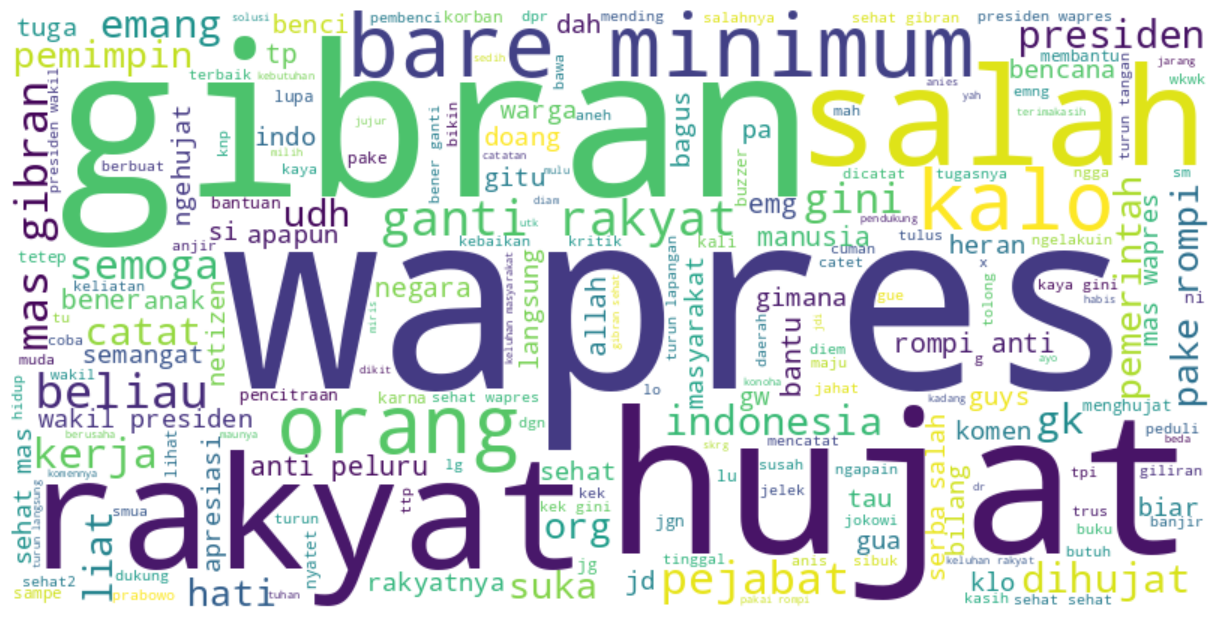

In [5]:
from wordcloud import WordCloud

def clean_text_for_indobert(text):
    text = text.lower()
    # remove content inside parentheses (so words in (...) are excluded)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleanedTxt = df['text'].apply(clean_text_for_indobert)
wordcloudtxt = cleanedTxt.apply(tc.tokenizingText).apply(tc.filteringText)
    
# Convert list of tokens back to string
wordcloud_text = ' '.join(wordcloudtxt.apply(lambda x: ' '.join(x)))

# Create wordcloud from cleaned text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

# Display wordcloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


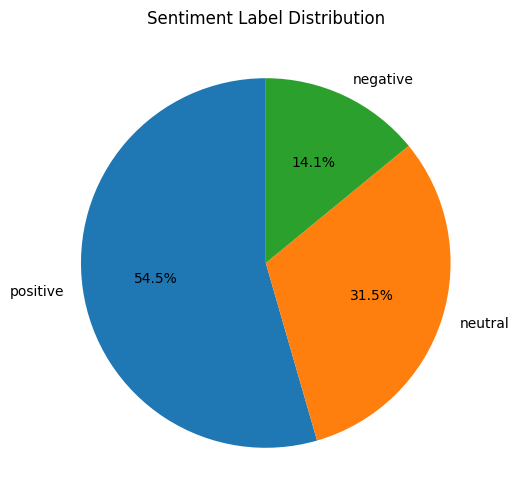

In [6]:
# Count sentiment labels
sentiment_counts = df['sentiment_label'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Sentiment Label Distribution")
plt.show()

In [7]:
x = pd.to_datetime(df['createTime'], unit='s')

df_regression = pd.DataFrame()
start_time = x.min()

df_regression['x'] = (x - start_time).dt.total_seconds() / 3600
df_regression['y'] = df['sentiment_score']


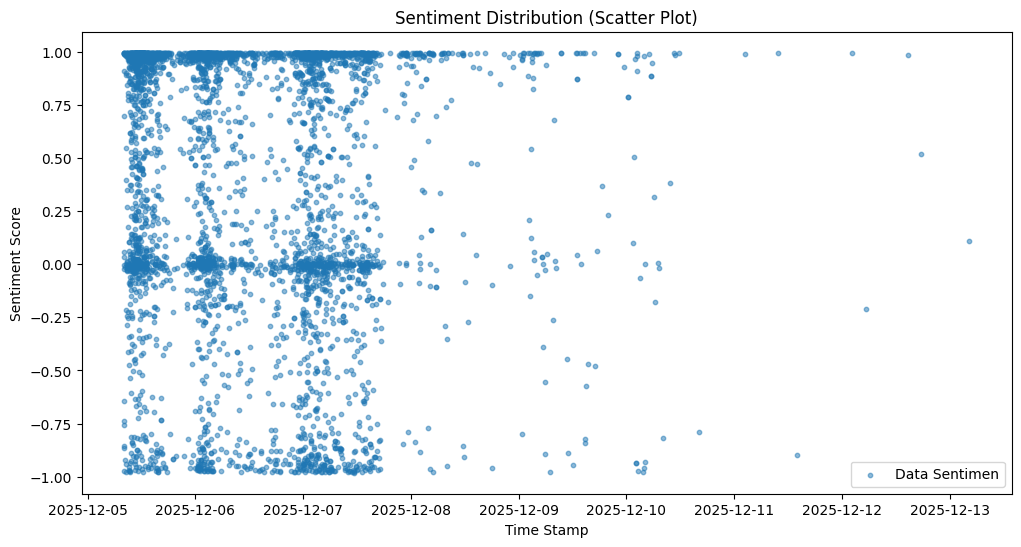

In [8]:
# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(x, df['sentiment_score'], alpha=0.5, s=10, label='Data Sentimen')
plt.title("Sentiment Distribution (Scatter Plot)")
plt.xlabel("Time Stamp" )
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

In [9]:
def get_quantile_knots(x_data, n_knots):
    percentiles = np.linspace(0, 100, n_knots + 2)[1:-1]
    knots = np.percentile(x_data, percentiles)
    return knots

def create_spline_features(x_data, knots):
    N = len(x_data)
    X_matrix = x_data.reshape(-1, 1)
    
    for k in knots:
        spline_col = np.maximum(0, x_data - k).reshape(-1, 1)
        X_matrix = np.hstack([X_matrix, spline_col])
        
    return X_matrix

def calculate_gcv(y_true, y_pred, n_knots):
    n = len(y_true)
    df = 1 + 1 + n_knots  # Intercept + Slope + Knots
    mse = np.mean((y_true - y_pred)**2)
    # Proteksi pembagian nol
    if (1 - df/n) <= 0: return float('inf') 
    penalty = (1 - (df / n)) ** 2
    return mse / penalty

def auto_tune_spline(x_data, y_data , max_knots):
    best_n = 1
    best_score = float('inf')
    
    best_model_obj = None
    best_knots_loc = None
    

    for n in range(1, max_knots + 1):
        current_knots = get_quantile_knots(x_data, n)
        X_spline = create_spline_features(x_data, current_knots)
        
        model = Model()
        model.fit(X_spline, y_data)
        y_pred = model.predict(X_spline)
        
        score = calculate_gcv(y_data, y_pred, n)
        
        is_best = ""
        if score < best_score:
            best_score = score
            best_n = n
        
            best_knots_loc = current_knots
            is_best = "*" 
    
    return best_n, best_knots_loc

In [10]:
df_regression_indexed = df_regression.set_index(pd.to_datetime(df['createTime'], unit='s'))

df_resampled = df_regression_indexed['y'].resample('3h').mean()
df_resampled = df_resampled.dropna()

start_time = df_resampled.index.min()
df_regression_resampled = pd.DataFrame()
df_regression_resampled['x'] = (df_resampled.index - start_time).total_seconds() / 3600
df_regression_resampled['y'] = df_resampled.values
df_regression

,x,y
0,3.123611,-0.014373
1,1.787500,0.994941
2,0.094722,0.035081
3,1.143889,-0.009545
4,0.086944,0.911693
...,...,...
4140,17.830000,0.990931
4141,17.756389,0.964800
4142,17.742778,0.978314
4143,17.724722,0.994848


In [11]:
x = df_regression_resampled['x'].values
y = df_resampled.values
n_knots = 7
best_knots = get_quantile_knots(x, n_knots)
print(f"Lokasi Knots ditemukan di x = {np.round(best_knots, 2)}")
X_spline = create_spline_features(x, best_knots)

Lokasi Knots ditemukan di x = [ 18.75  37.5   56.25  75.    93.75 112.5  144.75]


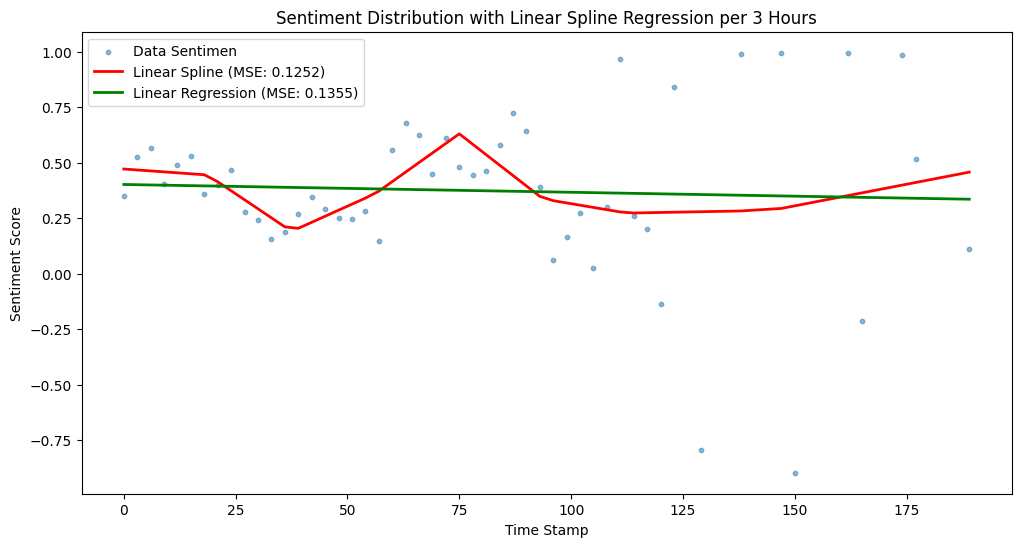

In [12]:
from LR import Model

model = Model()
model.fit(X_spline, y)
y_pred = model.predict(X_spline)

model_no_spline = Model()
model_no_spline.fit(x.reshape(-1, 1), y)
y_pred_linear = model_no_spline.predict(x.reshape(-1, 1))

# Calculate MSE
mse_spline = mean_squared_error(y, y_pred)
mse_linear = mean_squared_error(y, y_pred_linear)

plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.5, s=10, label='Data Sentimen')
plt.plot(x, y_pred, color='red', linewidth=2, label=f'Linear Spline (MSE: {mse_spline:.4f})')
plt.plot(x, y_pred_linear, color='green', linewidth=2, label=f'Linear Regression (MSE: {mse_linear:.4f})')

plt.title("Sentiment Distribution with Linear Spline Regression per 3 Hours")
plt.xlabel("Time Stamp")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

In [13]:
model.show_equation()

'y ≈ 0.47 + (-0.00 * x_1) + (-0.01 * x_2) + (0.02 * x_3) + (0.01 * x_4) + (-0.03 * x_5) + (0.01 * x_6) + (0.00 * x_7) + (0.00 * x_8)'